In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import theano
import theano.tensor as tt
import os
import utils
import make_data
from scipy.linalg import block_diag
theano.config.exception_verbosity='high'
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Settings

In [2]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'


tools = utils.utils()
c = tools.c
data = make_data.make_data(z_max, res , path)


DESI = data.get_DESI(new=True)
WFIRST = data.get_WFIRST(new=True)
CC = data.get_CC(new=True)
DSS = data.get_DSS(new=True)
BOSS = data.get_BOSS(new=True)
eBOSS = data.get_eBOSS(new=True)
Wigglez = data.get_Wigglez(new=True)
DS17 = data.get_DS17(new=True)
CMB = data.get_CMB(new=True)
FCMB = data.get_FCMB(new=True)

In [3]:
n_samples = 100
n_tune = 100
datadict = {'DESI': DESI,
            'WFIRST': WFIRST,
            'CC': CC,
            'DS17': DS17, 
            'BOSS': BOSS,
            'eBOSS': eBOSS,
            'Wigglez': Wigglez,
            'DSS': DSS,
            'CMB': CMB, 
            'FCMB': FCMB}

#datasets = ['CC', 'DS17', 'BOSS', 'eBOSS', 'CMB']
datasets = ['DESI', 'CMB']

need_dM = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DS17', 'CMB']
need_fs8 = ['DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DSS']
need_rd = ['BOSS', 'eBOSS', 'CMB']

if any(dataset in datasets for dataset in need_dM):
    get_dM=True 
else:
    get_dM=False
    
if any(dataset in datasets for dataset in need_fs8):
    get_fs8=True
else:
    get_fs8=False
    
if any(dataset in datasets for dataset in need_rd):
    get_rd = True
else:
    get_rd = False

In [4]:
DESI['data']

array([7.32047995e+01, 7.41636320e+01, 8.12936089e+01, 8.49825310e+01,
       9.37885119e+01, 9.73509651e+01, 1.00841842e+02, 1.11122520e+02,
       1.16173373e+02, 1.24170775e+02, 1.30630072e+02, 1.38420304e+02,
       1.45052596e+02, 1.52948203e+02, 1.65122735e+02, 1.66157789e+02,
       1.70575940e+02, 1.95455613e+02, 5.57891352e+02, 8.50594176e+02,
       1.04690855e+03, 1.25051881e+03, 1.37502048e+03, 1.47241811e+03,
       1.57534483e+03, 1.65710982e+03, 1.70827769e+03, 1.73945313e+03,
       1.76697813e+03, 1.78947526e+03, 1.82429233e+03, 1.81067394e+03,
       1.77183864e+03, 1.84092349e+03, 1.88115921e+03, 1.83597601e+03,
       4.29317219e-01, 4.44936025e-01, 4.53978384e-01, 4.46108770e-01,
       4.63944929e-01, 4.60239158e-01, 4.51238124e-01, 4.39809794e-01,
       4.34005748e-01, 4.22418487e-01, 4.13355487e-01, 3.98984112e-01,
       3.97135590e-01, 3.77510189e-01, 3.78203916e-01, 3.93030566e-01,
       3.67141965e-01, 3.27607370e-01])

In [5]:
CMB['data']

array([1.02340708])

In [6]:
data = np.array([])
data_cov = np.array([])
for dataset_name in datasets:
    dataset = datadict[dataset_name]
    data = np.concatenate([data, dataset['data']])
    data_cov = block_diag(data_cov, dataset['cov'])
data_cov = data_cov[1:]

# Plotting

In [7]:
z_planck = z_arr[z_arr<1085]
Planck = tools.get_preds(z_planck, mode='Planck')

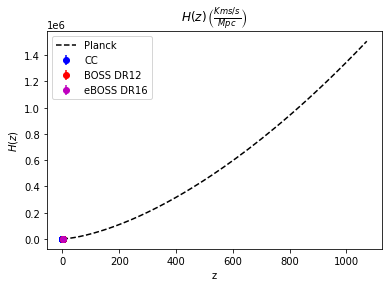

In [8]:
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
#plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')


# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')  

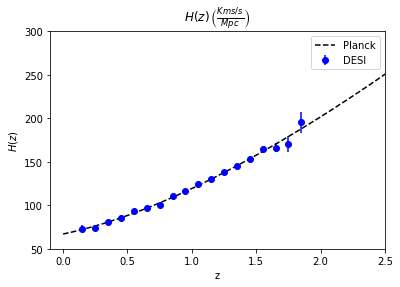

In [9]:
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['H_data'], yerr = DESI['H_err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')  

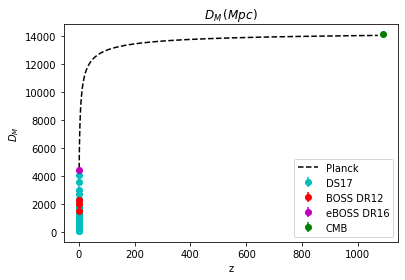

In [10]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')
plt.errorbar(CMB['z'], (1/CMB['data'])*(100*CMB['rd']), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

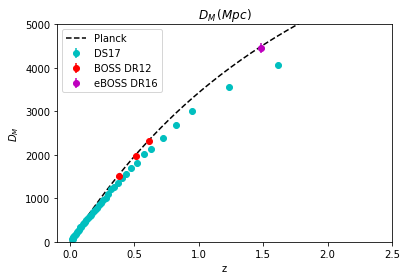

In [11]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

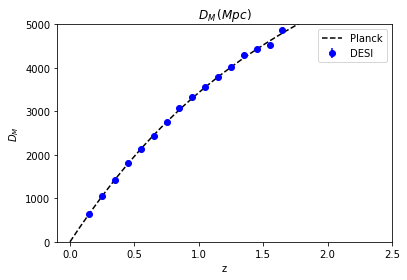

In [12]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], (1+DESI['z'])*DESI['dA_data'], yerr=DESI['dA_err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')  

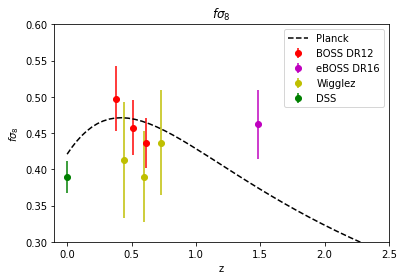

In [13]:
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')  

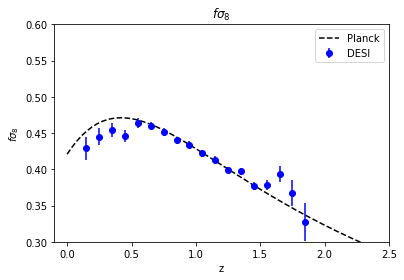

In [14]:
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], DESI['fs8_data'], yerr=DESI['fs8_err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')  

In [15]:
with pm.Model() as model:
    #ℓ = pm.InverseGamma("ℓ", alpha=2, beta=z_max/2) 
    ℓ = pm.InverseGamma("ℓ", alpha=3, beta=0.5) 
    #ℓ = pm.Uniform("ℓ", 10, 1000) 
    η = pm.HalfNormal("η", sigma=0.3) 
    wm0 = pm.Uniform("wm0", 0.1, 0.2) 
    wL0 = pm.Uniform("wL0", 0.2, 0.4) 
    wr0 = (2.47+1.71)*10**-5
    gp_cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Mean of the gp
    H = pm.Deterministic('H', 100*tt.sqrt(wm0*(1+z_arr)**3+wr0*(1+z_arr)**4+wL0))
    
    #Set up Gaussian process
    DH_gp = gp.prior("DH_gp", X=x_arr[:, None]) 
    H_gp = pm.Deterministic("H_gp", tt.as_tensor_variable(H)) #*(1+DH_gp)))
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp[0]))
    
    if get_dM:
        dH_gp = pm.Deterministic("dH", tt.as_tensor_variable((c/1000)*(1+z_arr)/H_gp))
        dM_rec_gp = tt.zeros(len(z_arr)+1)
        dM_rec_gp = tt.inc_subtensor(dM_rec_gp[1:],
                  tt.as_tensor_variable(dx*tt.cumsum(dH_gp)))
        dM_trap_gp = tt.as_tensor_variable(0.5*(dM_rec_gp[1:]+dM_rec_gp[:-1])-0.5*dM_rec_gp[1])
        dM_gp = pm.Deterministic('dM_gp', dM_trap_gp)
        #dM_gp = pm.Deterministic('dM_gp', dM_rec_gp[:-1])
        dA_gp = pm.Deterministic('dA_gp', dM_gp/(1+z_arr))
        dL_gp = pm.Deterministic('dL_gp', dM_gp*(1+z_arr))
        
    if get_rd:
        #https://arxiv.org/pdf/2106.00428.pdf
        wb0 =  pm.Uniform("wb0", 0.02224, 0.02228)
        a1 = 0.00785436
        a2 = 0.177084
        a3 = 0.00912388
        a4 = 0.618711
        a5 = 11.9611
        a6 = 2.81343
        a7 = 0.784719
        rd_gp = tt.as_tensor_variable(1/(a1*wb0**a2+a3*wm0**a4+a5*wb0**a6*wm0**a7))  
        
    if get_fs8:
        s80 = pm.Normal("s80", 0.8, 0.5)
        Wm0 =  pm.Deterministic('Wm0', wm0*(100/H_gp[0])**2)
        E_gp = pm.Deterministic('E_gp', H_gp/H_gp[0])
        
        d = tt.zeros(len(z_arr))
        y = tt.zeros(len(z_arr))
        d = tt.inc_subtensor(d[-1], a_arr[-1])
        y = tt.inc_subtensor(y[-1], E_gp[0]*a_arr[-1]**3)
        for i in np.arange(1, len(z_arr)):
            A0 = -1.5*Wm0/(a_arr[-i]*E_gp[-i])
            B0 = -1./(a_arr[-i]**2*E_gp[-i])
            A1 = -1.5*Wm0/(a_arr[-(i+1)]*E_gp[-(i+1)])
            B1 = -1./(a_arr[-(i+1)]**2*E_gp[-(i+1)])
            y = tt.inc_subtensor(y[-(i+1)], (1-0.5*dx**2*A0*B0)*y[-i]-0.5*(A0+A1)*dx*d[-i])
            d = tt.inc_subtensor(d[-(i+1)], -0.5*(B0+B1)*dx*y[-i]+(1-0.5*dx**2*A0*B0)*d[-i])
        
        fs8_gp = pm.Deterministic('fs8_gp', s80*y/(a_arr**2*E_gp*d[0]))
        s8_gp = pm.Deterministic('s8_gp', s80*d/d[0])
    
    theory = tt.as_tensor_variable([])

In [ ]:
if 'DESI' in datasets:
    print('Adding DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[DESI['idx']]+(H_gp[DESI['idx']+1]-H_gp[DESI['idx']])*DESI['U']))
        DESI_dA = pm.Deterministic('DESI_dA',
                  tt.as_tensor_variable(dA_gp[DESI['idx']]+(dA_gp[DESI['idx']+1]-dA_gp[DESI['idx']])*DESI['U']))
        DESI_fs8 = pm.Deterministic('DESI_fs8',
                   tt.as_tensor_variable(fs8_gp[DESI['idx']]+(fs8_gp[DESI['idx']+1]-fs8_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_H, DESI_dA, DESI_fs8])
        
if 'WFIRST' in datasets:
    print('Adding WFIRST')
    with model:
        WFIRST_E = pm.Deterministic('WFIRST_E',
                   tt.as_tensor_variable(E_gp[WFIRST['idx']]+(E_gp[WFIRST['idx']+1]-E_gp[WFIRST['idx']])*WFIRST['U']))
        theory = tt.concatenate([theory, WFIRST_E])

if 'CC' in datasets:
    print('Adding CCs')
    with model:
        CC_H = pm.Deterministic("CC_H",
               tt.as_tensor_variable(H_gp[CC['idx']]+(H_gp[CC['idx']+1]-H_gp[CC['idx']])*CC['U']))
        theory = tt.concatenate([theory, CC_H])
        
if 'DS17' in datasets:
    print('Adding Pantheon')
    with model:
        M = pm.Normal('M', mu=-19.0, sigma=3)
        u_gp = tt.zeros(len(z_arr))
        u_gp = tt.inc_subtensor(u_gp[1:], tt.as_tensor_variable(5*tt.log10(dL_gp[1:])+25+M))
        u_gp = tt.inc_subtensor(u_gp[0], tt.as_tensor_variable(5*tt.log10(dL_gp[1])+25+M))
        DS17_u = pm.Deterministic("DS17_u",
                 tt.as_tensor_variable(u_gp[DS17['idx']]+(u_gp[DS17['idx']+1]-u_gp[DS17['idx']])*DS17['U']))
        theory = tt.concatenate([theory, DS17_u])
        
if 'BOSS' in datasets:
    print('Adding BOSS')
    with model:
        #Get alpha_perp and alpha_para 
        B_para_f = pm.Deterministic("B_para_f", H_gp*rd_gp/BOSS['rd'])
        B_perp_f = pm.Deterministic("B_perp_f", dM_gp*BOSS['rd']/rd_gp)
        
        B_para = pm.Deterministic("B_para", 
                    tt.as_tensor_variable(B_para_f[BOSS['idx']]+(B_para_f[BOSS['idx']+1]-B_para_f[BOSS['idx']])*BOSS['U']))
        B_perp = pm.Deterministic("B_perp", 
                tt.as_tensor_variable(B_perp_f[BOSS['idx']]+(B_perp_f[BOSS['idx']+1]-B_perp_f[BOSS['idx']])*BOSS['U']))
        B_fs8 = pm.Deterministic("B_fs8", 
                   tt.as_tensor_variable(fs8_gp[BOSS['idx']]+(fs8_gp[BOSS['idx']+1]-fs8_gp[BOSS['idx']])*BOSS['U']))
        
        theory = tt.concatenate([theory, B_para, B_perp, B_fs8])
        
if 'eBOSS' in datasets:
    print('Adding eBOSS')
    with model:
        eB_para_f = pm.Deterministic("eB_para_f", dH_gp/rd_gp)
        eB_perp_f = pm.Deterministic("eB_perp_f", dH_gp/rd_gp)
        
        eB_para = pm.Deterministic("eB_para", 
                    tt.as_tensor_variable(eB_para_f[eBOSS['idx']]+(eB_para_f[eBOSS['idx']+1]-eB_para_f[eBOSS['idx']])*eBOSS['U']))
        eB_perp = pm.Deterministic("eB_perp", 
                tt.as_tensor_variable(eB_perp_f[eBOSS['idx']]+(eB_perp_f[eBOSS['idx']+1]-eB_perp_f[eBOSS['idx']])*eBOSS['U']))
        eB_fs8 = pm.Deterministic("eB_fs8", 
                   tt.as_tensor_variable(fs8_gp[eBOSS['idx']]+(fs8_gp[eBOSS['idx']+1]-fs8_gp[eBOSS['idx']])*eBOSS['U']))
        
        theory = tt.concatenate([theory, eB_para, eB_perp, eB_fs8])

if 'Wigglez' in datasets:
    print('Adding Wigglez')
    with model:
        Wigglez_fs8 = pm.Deterministic("Wigglez_fs8",
                    tt.as_tensor_variable(fs8_gp[Wigglez['idx']]+(fs8_gp[Wigglez['idx']+1]-fs8_gp[Wigglez['idx']])*Wigglez['U']))
        theory = tt.concatenate([theory, Wigglez_fs8])

if 'DSS' in datasets:
    print('Adding DSS')
    with model:
        DSS_fs8 = pm.Deterministic("fs8_eBOSS", tt.as_tensor_variable(fs8_gp[DSS['idx']]))
        theory = tt.concatenate([theory, DSS_fs8])

if 'CMB' in datasets:
    print('Adding CMB')
    with model:
        dM_star = tt.as_tensor_variable(dM_gp[CMB['idx']]+(dM_gp[CMB['idx']+1]-dM_gp[CMB['idx']])*CMB['U'])
        t100 = pm.Deterministic('t100', 100*rd_gp/dM_star) 
        theory = tt.concatenate([theory, t100])
        
if 'FCMB' in datasets:
    print('Adding FCMB')
    with model:
        CMB_H = pm.Deterministic('CMB_H',
                  tt.as_tensor_variable(H_gp[FCMB['idx']]+(H_gp[FCMB['idx']+1]-H_gp[FCMB['idx']])*FCMB['U']))
        theory = tt.concatenate([theory, CMB_H])
        
with model:
    lkl= pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)
    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)


Adding DESI
Adding CMB


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
pm.summary(trace)['r_hat'][["ℓ","η"]]

In [ ]:
pm.summary(trace)['mean'][["ℓ","η"]]

In [ ]:
#trace.posterior['t100']

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["DH_gp"][0, :, :], z_arr[:, None])

# axis labels and title
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("DH(z)")
plt.title("DH(z)")
plt.legend();

In [ ]:
H_fit = 100*np.sqrt(0.138*(1+z_arr)**3+(2.47+1.71)*10**-5*(1+z_arr)**4+0.30)
dM_fit = np.zeros(len(z_arr)+1)
dM_fit[1:] = dx*np.cumsum((1+z_arr)*(c/1000)/H_fit)
dM_fit = 0.5*(dM_fit[1:]+dM_fit[:-1])-0.5*dM_fit[1]

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_planck, Planck['Hkms_arr'], "k--", label=r'$CLASS$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
plt.plot(z_arr, H_fit, 'b-.', label='formula')

if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')


# axis labels and title
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_planck, Planck['Hkms_arr'], "k--", label=r'$LCDM$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dM_gp"][0, :, :], z_arr[:, None])

plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.plot(z_arr, dM_fit, 'b-.', label='formula')

if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')
if 'CMB' in datasets:
    plt.errorbar(CMB['z'], (1/CMB['data'])*(100*CMB['rd']), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')

# axis labels and title
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dM_gp"][0, :, :],
             z_arr[:, None])
plt.plot(z_arr, dM_fit, 'b-.', label='formula')
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')
if 'CMB' in datasets:
    plt.errorbar(CMB['z'], (1/CMB['data'])*(100*CMB['rd']), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')

# axis labels and title
plt.xlim(-.1, 2.5)
plt.ylim(0, 5200)
plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp"][0, :, :],
             z_arr[:, None])

plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS')
if 'Wigglez' in datasets:
    plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
if 'DSS' in datasets:
    plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlim(-.1, 2.5)
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["s8_gp"])[0, :, :],
             z_arr[:, None])

# plot the data and the true latent function
ax.plot(z_planck[:, None], Planck['s8_arr'], "k--", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("sigma8(z)")
plt.legend();

In [ ]:
#Save
filename = ''
for dataset in datasets:
    filename+=dataset+'_'
path = filename+'{}_{}_t'.format(n_samples, n_tune)

n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
Hz =np.array(trace.posterior["H_gp"])
Hz = Hz.reshape(-1, Hz.shape[-1])
H0 = np.array(trace.posterior["H0_gp"]).flatten()
h = H0/100
Omega_m = np.array(trace.posterior["wm0"]).flatten()/h**2
Omega_L = np.array(trace.posterior["wL0"]).flatten()/h**2


if get_dM:
    dMz = np.array(trace.posterior["dM_gp"])
    dMz = dMz.reshape(-1, dMz.shape[-1])
else:
    dMz = None

if get_rd:
    Omega_b = np.array(trace.posterior["wmb"]).flatten()/h**2
else:
    Omega_b = None
    
if get_fs8:
    s8z = np.array(trace.posterior["s8_gp"])
    s8z = s8z.reshape(-1, s8z.shape[-1])
    fs8z = np.array(trace.posterior["fs8_gp"])
    fs8z = fs8z.reshape(-1, fs8z.shape[-1])
    s80 = np.array(trace.posterior["s80"]).flatten()
    S80 = s80*np.sqrt(Omega_m/0.3)
else: 
    s8z = None 
    fs8z = None
    s80 = None
    S80 = None

if 'DS17' in datasets:
    M = np.array(trace.posterior["M"]).flatten()
else:
    M = None

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         z_arr = z_arr,
         n=n,
         l=l,
         DHz = DHz,
         Hz=Hz,
         dMz=dMz,
         s8z=s8z,
         fs8z=fs8z,
         H0=H0,
         Omega_m=Omega_m,
         Omega_b=Omega_b,
         Omega_L=Omega_L,
         s80=s80,
         S80=S80)